In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 75,
        x_rate = 0.5,
        m_rate = 0.6,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.5,
        grow_factor = 0.5,
        scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

C:\Users\tcumi\github_repo\neural-network\python\ga.py:189: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)
C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


Checkpoint 100, Accuracy: 0.8580246913580247, Loss: 0.5823559937653718
Checkpoint 200, Accuracy: 0.8580246913580247, Loss: 0.5701082724112051
Checkpoint 300, Accuracy: 0.8703703703703703, Loss: 0.5718291953757957
Checkpoint 400, Accuracy: 0.8703703703703703, Loss: 0.5639790429009331
Checkpoint 500, Accuracy: 0.8703703703703703, Loss: 0.563625900833695


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None:
        title = '{} VS {}'.format(x_label, y_label)
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

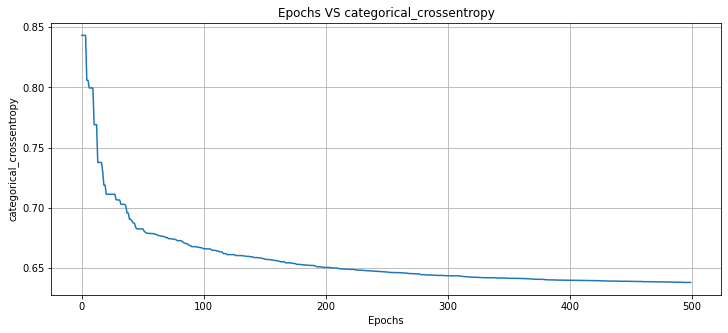

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.6221541 ]
 [0.26957154]
 [0.10827437]]
[1. 0. 0.] <-> [[0.59409964]
 [0.21146505]
 [0.19443531]]
[1. 0. 0.] <-> [[0.9052905 ]
 [0.06133026]
 [0.03337924]]
[1. 0. 0.] <-> [[0.9081732 ]
 [0.05955714]
 [0.03226959]]
[1. 0. 0.] <-> [[0.91309476]
 [0.05650566]
 [0.03039955]]
[1. 0. 0.] <-> [[0.8955486 ]
 [0.06756054]
 [0.03689082]]
[1. 0. 0.] <-> [[0.57447076]
 [0.2057249 ]
 [0.21980435]]
[1. 0. 0.] <-> [[0.35373503]
 [0.3246733 ]
 [0.32159162]]
[1. 0. 0.] <-> [[0.91173106]
 [0.05734679]
 [0.03092213]]
[1. 0. 0.] <-> [[0.9029277 ]
 [0.06276952]
 [0.03430285]]
[0. 1. 0.] <-> [[0.8849132 ]
 [0.07481093]
 [0.04027592]]
[1. 0. 0.] <-> [[0.91340965]
 [0.05631233]
 [0.03027813]]
[1. 0. 0.] <-> [[0.91345143]
 [0.05628669]
 [0.03026198]]
[1. 0. 0.] <-> [[0.9082899 ]
 [0.05948471]
 [0.03222544]]
[1. 0. 0.] <-> [[0.90936744]
 [0.05881444]
 [0.03181814]]
[1. 0. 0.] <-> [[0.9083206 ]
 [0.05946553]
 [0.03221377]]
[1. 0. 0.] <-> [[0.9108956 ]
 [0.05786453]
 [0.03123993]]
[0. 0. 1.] <->

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


In [12]:
# Testing Performance

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8580246913580247, 'mean_square_error': 2.8829246244167943, 'categorical_crossentropy': 0.5823559937653718, 'precision': 0.7870370370370371, 'recall': 0.7870370370370371, 'f1': 0.7870370370370371, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 14, 'tn_hit': 14, 'fn_hit': 3}, 1: {'tp_hit': 5, 'fp_hit': 9, 'tn_hit': 84, 'fn_hit': 10}, 2: {'tp_hit': 3, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 10}}, 'checkpoint': 100} 


{'accuracy': 0.8580246913580247, 'mean_square_error': 2.884480213199163, 'categorical_crossentropy': 0.5701082724112051, 'precision': 0.7870370370370371, 'recall': 0.7870370370370371, 'f1': 0.7870370370370371, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 14, 'tn_hit': 14, 'fn_hit': 2}, 1: {'tp_hit': 0, 'fp_hit': 4, 'tn_hit': 89, 'fn_hit': 15}, 2: {'tp_hit': 7, 'fp_hit': 5, 'tn_hit': 90, 'fn_hit': 6}}, 'checkpoint': 200} 


{'accuracy': 0.8703703703703703, 'mean_square_error': 2.875122173704435, 'categorical_crossentropy': 0.5718291953757957, 'precision': 

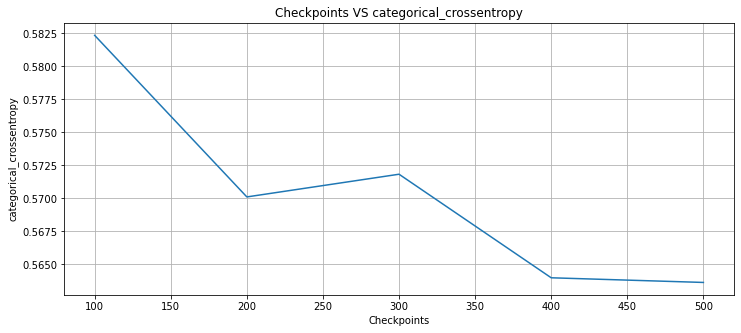

In [14]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

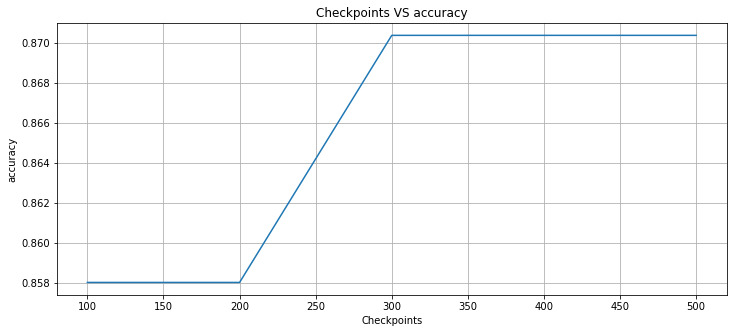

In [15]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [16]:
print(model)

Layer 1
Neuron 0: weights:
[[-1.0109212]
 [-2.8402793]
 [-3.       ]
 [ 0.7403337]
 [-2.3200576]]
 bias: [0.07189053]

Neuron 1: weights:
[[ 2.6416812 ]
 [-1.2094051 ]
 [-0.7685097 ]
 [-0.02137826]
 [-2.7736356 ]]
 bias: [3.]

Neuron 2: weights:
[[-3.       ]
 [-3.       ]
 [-2.9757686]
 [-1.2381238]
 [-3.       ]]
 bias: [-2.5971446]

Neuron 3: weights:
[[-1.4253271]
 [ 0.5112631]
 [ 1.4234108]
 [ 1.8176962]
 [-1.1930318]]
 bias: [-3.]

$
Layer 2
Neuron 0: weights:
[[-0.52980334]
 [ 2.0567288 ]
 [ 3.        ]
 [-2.9607651 ]]
 bias: [0.81902444]

Neuron 1: weights:
[[ 2.5484703]
 [-0.0408598]
 [-1.0739633]
 [ 1.9916272]]
 bias: [1.1000515]

Neuron 2: weights:
[[0.7238071 ]
 [0.59436   ]
 [0.04112467]
 [3.        ]]
 bias: [0.54933]

$

